In [6]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["first_col"] = np.random.normal(0, 1, size=10000)
pd_df["second_col"] = np.random.normal(0, 10, size=10000)
df = spark.createDataFrame(pd_df)
df.printSchema()

root
 |-- first_col: double (nullable = true)
 |-- second_col: double (nullable = true)



In [7]:
from pyspark.sql.functions import udf

@udf('double', 'double')
def same_boat(series_one, series_two):
    return stats.ks_2samp(series_one, series_two)[1]

df.withColumn('result', same_boat(df.first_col, df.second_col))

DataFrame[first_col: double, second_col: double, result: double]

In [8]:
df.select('result').take(5)

AnalysisException: "cannot resolve '`result`' given input columns: [first_col, second_col];;\n'Project ['result]\n+- LogicalRDD [first_col#8, second_col#9], false\n"

In [9]:
# Use udf to define a row-at-a-time udf
@udf('float')
# Input/output are both a single double value
def plus_one(v):
      return v + 1

df.withColumn('v2', plus_one(df.first_col))

DataFrame[first_col: double, second_col: double, v2: double]

In [11]:
df.select("v2").show(10)

AnalysisException: "cannot resolve '`v2`' given input columns: [first_col, second_col];;\n'Project ['v2]\n+- LogicalRDD [first_col#8, second_col#9], false\n"

In [20]:
type(df.select("first_col").take(1)[0].asDict()["first_col"])

float

In [24]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
from pyspark.sql.functions import pandas_udf, PandasUDFType

spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["v"] = np.random.normal(0, 1, size=10000)
pd_df["w"] = np.random.normal(0, 10, size=10000)
df = spark.createDataFrame(pd_df)
df.printSchema()

@pandas_udf('double')
def cdf(v):
    return pd.Series(stats.norm.cdf(v))


df = df.withColumn('cumulative_probability', cdf(df.v))

root
 |-- v: double (nullable = true)
 |-- w: double (nullable = true)



In [27]:
df.show(10)

+--------------------+-------------------+----------------------+
|                   v|                  w|cumulative_probability|
+--------------------+-------------------+----------------------+
|  1.2511375087210854| -1.034707392518126|    0.8945578435768884|
|  1.3405766102786676|  9.896160693027223|    0.9099710222444131|
|  0.4199490519504442|  8.118257845666983|    0.6627386635319077|
|  1.0576158377715044|-1.0026550640649698|    0.8548846904828724|
| -0.1069871071381816| 16.998369581365107|    0.4573996040291934|
|-0.05094007982986...|  8.619683737811465|    0.4796866339328072|
| -0.1946733592161296|-12.328845037606955|   0.42282433456862745|
|  0.9075942187943913|-0.6907124183420987|     0.817953675071265|
|  1.2021000019847259|-11.947185634021995|    0.8853376071940642|
| -0.5300899230950974|-3.8451747490011208|   0.29802479270328486|
+--------------------+-------------------+----------------------+
only showing top 10 rows



In [30]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import ArrayType, FloatType

spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["v"] = np.random.normal(0, 1, size=10000)
pd_df["w"] = np.random.normal(0, 10, size=10000)
df = spark.createDataFrame(pd_df)
df.printSchema()

@pandas_udf()
def similarity_score(v, w):
    return stats.ks_2samp(v, w)[1]


df = df.withColumn('sameness', similarity_score(df.v, df.w))

root
 |-- v: double (nullable = true)
 |-- w: double (nullable = true)



In [31]:
df.show(10)

Py4JJavaError: An error occurred while calling o648.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 8.0 failed 1 times, most recent failure: Lost task 0.0 in stage 8.0 (TID 8, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 283, in dump_stream
    for series in iterator:
  File "<string>", line 1, in <lambda>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 96, in <lambda>
    return lambda *a: (verify_result_length(*a), arrow_return_type)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 90, in verify_result_length
    "Pandas.Series, but is {}".format(type(result)))
TypeError: Return type of the user-defined function should be Pandas.Series, but is <class 'numpy.float64'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3384)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2759)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:255)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:292)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 283, in dump_stream
    for series in iterator:
  File "<string>", line 1, in <lambda>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 96, in <lambda>
    return lambda *a: (verify_result_length(*a), arrow_return_type)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 90, in verify_result_length
    "Pandas.Series, but is {}".format(type(result)))
TypeError: Return type of the user-defined function should be Pandas.Series, but is <class 'numpy.float64'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [33]:
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import ArrayType, FloatType

spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["y"] = np.random.normal(0, 1, size=10000)
pd_df["x1"] = np.random.normal(0, 10, size=10000)
pd_df["x2"] = np.random.normal(0, 10, size=10000)
pd_df["id"] = list(range(len(pd_df)))
df = spark.createDataFrame(pd_df)
df.printSchema()

# df has four columns: id, y, x1, x2

group_column = 'id'
y_column = 'y'
x_columns = ['x1', 'x2']
schema = df.select(group_column, *x_columns).schema

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def ols(pdf):
    group_key = pdf[group_column].iloc[0]
    y = pdf[y_column]
    X = pdf[x_columns]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    return pd.DataFrame([[group_key] + [model.params[i] for i in   x_columns]], columns=[group_column] + x_columns)

results = df.groupby(group_column).apply(ols)

root
 |-- y: double (nullable = true)
 |-- x1: double (nullable = true)
 |-- x2: double (nullable = true)
 |-- id: long (nullable = true)



In [35]:
results.show(5)

+----+--------------------+--------------------+
|  id|                  x1|                  x2|
+----+--------------------+--------------------+
|  26|-0.01862032270205...|4.334820367482851E-5|
|  29|-0.13525088251462714|-0.14541598702846917|
| 474|-0.05483234343675036|0.032459350929867826|
| 964| 0.05086723217848549|-0.11074908512128061|
|1677|0.002664459816489...|-0.00109608642489...|
+----+--------------------+--------------------+
only showing top 5 rows



In [54]:
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["y"] = np.random.normal(0, 1, size=10000)
pd_df["x1"] = np.random.normal(0, 10, size=10000)
pd_df["x2"] = np.random.normal(0, 10, size=10000)
pd_df["id"] = list(range(len(pd_df)))
df = spark.createDataFrame(pd_df)
df.printSchema()

# df has four columns: id, y, x1, x2

group_column = 'id'
y_column = 'y'
x_columns = ['x1', 'x2']

@pandas_udf(DoubleType, PandasUDFType.GROUPED_MAP)
def similarity_score(pdf):
    return pd.DataFrame({"result": stats.ks_2samp(pdf['x1'], pdf['x2'])[1]})

results = df.groupby(group_column).apply(similarity_score)

root
 |-- y: double (nullable = true)
 |-- x1: double (nullable = true)
 |-- x2: double (nullable = true)
 |-- id: long (nullable = true)



ValueError: Invalid function: 0-arg pandas_udfs are not supported. Instead, create a 1-arg pandas_udf and ignore the arg in your function.

In [48]:
dir()

['ArrayType',
 'BinaryType',
 'BooleanType',
 'ByteType',
 'DataType',
 'DateType',
 'DecimalType',
 'DoubleType',
 'FloatType',
 'In',
 'IntegerType',
 'LongType',
 'MapType',
 'NullType',
 'Out',
 'PandasUDFType',
 'ShortType',
 'SparkContext',
 'SparkSession',
 'StringType',
 'StructField',
 'StructType',
 'TimestampType',
 '_',
 '_15',
 '_16',
 '_17',
 '_18',
 '_19',
 '_20',
 '_21',
 '_25',
 '_34',
 '_37',
 '_46',
 '_7',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i46',
 '_i47',
 '_i48',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 

In [45]:
results.show(10)

Py4JJavaError: An error occurred while calling o1021.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 16.0 failed 1 times, most recent failure: Lost task 0.0 in stage 16.0 (TID 16, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 283, in dump_stream
    for series in iterator:
  File "<string>", line 1, in <lambda>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 108, in wrapped
    result = f(pd.concat(value_series, axis=1))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-44-50aecf5ed010>", line 27, in similarity_score
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py", line 348, in __init__
    mgr = self._init_dict(data, index, columns, dtype=dtype)
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py", line 459, in _init_dict
    return _arrays_to_mgr(arrays, data_names, index, columns, dtype=dtype)
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py", line 7356, in _arrays_to_mgr
    index = extract_index(arrays)
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py", line 7393, in extract_index
    raise ValueError('If using all scalar values, you must pass'
ValueError: If using all scalar values, you must pass an index

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3384)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2759)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:255)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:292)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 283, in dump_stream
    for series in iterator:
  File "<string>", line 1, in <lambda>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 108, in wrapped
    result = f(pd.concat(value_series, axis=1))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-44-50aecf5ed010>", line 27, in similarity_score
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py", line 348, in __init__
    mgr = self._init_dict(data, index, columns, dtype=dtype)
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py", line 459, in _init_dict
    return _arrays_to_mgr(arrays, data_names, index, columns, dtype=dtype)
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py", line 7356, in _arrays_to_mgr
    index = extract_index(arrays)
  File "/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py", line 7393, in extract_index
    raise ValueError('If using all scalar values, you must pass'
ValueError: If using all scalar values, you must pass an index

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [55]:
import pyspark.sql.functions as f

# define the function
def increment(x):
    return x + 1

import statsmodels.api as sm
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["col"] = np.random.normal(0, 1, size=10000)
df = spark.createDataFrame(pd_df)
df.printSchema()

# make the udf version
increment_udf = f.udf(increment)
df = df.withColumn('col_plus_1', increment_udf('col'))


root
 |-- col: double (nullable = true)



In [56]:
df.show(10)

+--------------------+-------------------+
|                 col|         col_plus_1|
+--------------------+-------------------+
| 0.43191988484739985|    1.4319198848474|
| -1.5433876839619418|-0.5433876839619418|
|   1.146462440713444|  2.146462440713444|
| -0.2642208016677398| 0.7357791983322601|
|  1.5112696739432383| 2.5112696739432385|
|  0.5870927612445772| 1.5870927612445773|
| -0.2987657615352133| 0.7012342384647867|
|  1.2247504785794168| 2.2247504785794168|
| 0.01215177237927024| 1.0121517723792703|
|-0.15320164014640136| 0.8467983598535986|
+--------------------+-------------------+
only showing top 10 rows



In [57]:
import pyspark_udaf
import logging


@pyspark_udaf.pandas_udaf(loglevel=logging.DEBUG)
def my_func(df):
    if df.empty:
        return
    df = df.groupby('country').apply(lambda x: x.drop('country', axis=1).describe())
    return df.reset_index()

spark.sparkContext.addFile('./pyspark_udaf.py')

df = spark.createDataFrame(
    data = [('DEU', 2, 1.0), ('DEU', 3, 8.0), ('FRA', 2, 6.0),
            ('FRA', 0, 8.0), ('DEU', 3, 8.0), ('FRA', 1, 3.0)],
    schema = ['country', 'feature1', 'feature2'])

stats_df = df.repartition('country').rdd.mapPartitions(my_func).toDF()
print(stats_df.toPandas())

   country level_1  feature1  feature2
0      FRA   count  3.000000  3.000000
1      FRA    mean  1.000000  5.666667
2      FRA     std  1.000000  2.516611
3      FRA     min  0.000000  3.000000
4      FRA     25%  0.500000  4.500000
5      FRA     50%  1.000000  6.000000
6      FRA     75%  1.500000  7.000000
7      FRA     max  2.000000  8.000000
8      DEU   count  3.000000  3.000000
9      DEU    mean  2.666667  5.666667
10     DEU     std  0.577350  4.041452
11     DEU     min  2.000000  1.000000
12     DEU     25%  2.500000  4.500000
13     DEU     50%  3.000000  8.000000
14     DEU     75%  3.000000  8.000000
15     DEU     max  3.000000  8.000000


In [64]:
@pyspark_udaf.pandas_udaf(loglevel=logging.DEBUG)
def my_func(df):
    if df.empty:
        return
    print(len(df))
    return pd.DataFrame({"result": stats.ks_2samp(df["feature1"], df["feature2"])})
    #return df.reset_index()

spark.sparkContext.addFile('./pyspark_udaf.py')

df = spark.createDataFrame(
    data = [('DEU', 2, 1.0), ('DEU', 3, 8.0), ('FRA', 2, 6.0),
            ('FRA', 0, 8.0), ('DEU', 3, 8.0), ('FRA', 1, 3.0)],
    schema = ['country', 'feature1', 'feature2'])

stats_df = df.repartition('country').rdd.mapPartitions(my_func).toDF()
stats_df = stats_df.toPandas()

In [63]:
stats_df

,result
0,1.000000
1,0.032622
2,0.666667
3,0.319724


In [66]:
from pyspark.sql.functions import udf, col

#sample data
a= spark.createDataFrame([("A", 20), ("B", 30), ("D", 80)],["Letter", "distances"])
label_list = ["Great", "Good", "OK", "Please Move", "Dead"]

def cate(label, feature_list):
    if feature_list == 0:
        return label[4]
    else:  #you may need to add 'else' condition as well otherwise 'null' will be added in this case
        return 'I am not sure!'

def udf_score(label_list):
    return udf(lambda l: cate(l, label_list))
a.withColumn("category", udf_score(label_list)(col("distances"))).show()

+------+---------+--------------+
|Letter|distances|      category|
+------+---------+--------------+
|     A|       20|I am not sure!|
|     B|       30|I am not sure!|
|     D|       80|I am not sure!|
+------+---------+--------------+



In [88]:
from pyspark.sql.functions import udf, col
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["col1"] = np.random.normal(0, 1, size=10000)
pd_df["col2"] = np.random.normal(0, 1, size=10000)
df = spark.createDataFrame(pd_df)
df.printSchema()

def ranker(list_one, list_two):
    return {
        # least stringent
        "ks_2samp": stats.ks_2samp(list_one, list_two)[1],
        # assumes a dependency structure
        "wilcoxon": stats.wilcoxon(list_one, list_two)[1],
        # most stringent
        "mann_whitney_u": stats.mannwhitneyu(list_one, list_two)[1]
    }

col1 = df.select('col1').collect()
col2 = df.select('col2').collect()

ranker([elem.col1 for elem in col1], [elem.col2 for elem in col2])

root
 |-- col1: double (nullable = true)
 |-- col2: double (nullable = true)



{'ks_2samp': 0.18499855104035948,
 'wilcoxon': 0.06307493720907432,
 'mann_whitney_u': 0.041798882087605925}

In [ ]:
from pyspark.sql.functions import udf, col
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pyspark

spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["col1"] = np.random.normal(0, 1, size=10000)
pd_df["col2"] = np.random.normal(0, 1, size=10000)
df = spark.createDataFrame(pd_df)
df.printSchema()

def ranker(list_one, list_two):
    return {
        # least stringent
        "ks_2samp": stats.ks_2samp(list_one, list_two)[1],
        # assumes a dependency structure
        "wilcoxon": stats.wilcoxon(list_one, list_two)[1],
        # most stringent
        "mann_whitney_u": stats.mannwhitneyu(list_one, list_two)[1]
    }

def transform_columns(data_frame: pyspark.sql.DataFrame, column_one: str, column_two: str) -> (list, list):
    listing_one = df.select(column_one).collect()
    listing_two = df.select(column_two).collect()
    listing_one = [elem.asDict()[column_one] for elem in listing_one]
    listing_two = [elem.asDict()[column_two] for elem in listing_two]
    return listing_one, listing_two


def similarity_score(data_frame: pyspark.sql.DataFrame, column_one:str, column_two: str) -> list:
    score_list = []
    col1_list, col2_list = transform_columns(data_frame, column_one, column_two)
    score_list.append(ranker(col1_list, col2_list))
    return score_list
  
similarity_score(df, "col1", "col2")

In [153]:
from pyspark.sql.functions import udf, col
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
from pyspark.sql.functions import pandas_udf, PandasUDFType, last
from pyspark.sql import functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta
from random import randint

stamp = datetime(2011,11,1)
spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["timestamp"] = [stamp+timedelta(minutes=randint(0,59), hours=hour_inc)
     for hour_inc in range(0, 50)]
pd_df["distance"] = [randint(2, 97) for _ in range(0, 50)]
#pd_df["col2"] = np.random.normal(0, 1, size=10000)
df = spark.createDataFrame(pd_df)
df.printSchema()

def get_last(df):
    expr = [last(col) for col in df.columns]
    dicter = df.groupBy().agg(*expr).take(1)[0].asDict()
    keys = list(dicter.keys())
    mapping = {}
    for key in keys:
        for column in df.columns:
            if column in key:
                mapping[key] = column
    return {mapping[key]:dicter[key] for key in dicter}

def sum_col(df, col):
    return df.select(F.sum(col)).collect()[0][0]

def summate(df):
    tmp_dataframe = pd.DataFrame()
    distances = []
    timestamps = []
    start_timestamp = df.select("timestamp").first().asDict()["timestamp"]
    end_timestamp = start_timestamp + timedelta(hours=1)
    last_timestamp = get_last(df)["timestamp"]
    segments_to_go = True
    while segments_to_go:
        to_sum = df.select("distance").filter(df.timestamp >= start_timestamp).filter(df.timestamp < end_timestamp)
        distances.append(sum_col(to_sum, "distance"))
        timestamps.append(end_timestamp)
        start_timestamp = df.filter(df.timestamp >= end_timestamp).select("timestamp").first().asDict()["timestamp"]
        end_timestamp = start_timestamp + timedelta(hours=1)
        if end_timestamp >= last_timestamp:
            segments_to_go = False
    tmp_dataframe["distance"] = distances
    tmp_dataframe["timestamp"] = timestamps
    return tmp_dataframe

result = summate(df)
# this is the code for the summation

root
 |-- timestamp: timestamp (nullable = true)
 |-- distance: long (nullable = true)



In [154]:
result

,distance,timestamp
0,183,2011-11-01 01:58:00
1,104,2011-11-01 03:40:00
2,79,2011-11-01 05:10:00
3,54,2011-11-01 06:57:00
4,113,2011-11-01 07:57:00
5,71,2011-11-01 09:52:00
6,127,2011-11-01 11:30:00
7,188,2011-11-01 13:16:00
8,163,2011-11-01 15:53:00
9,118,2011-11-01 17:45:00


In [170]:
from pyspark.sql.functions import udf, col
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
import pyspark
from pyspark.sql.functions import pandas_udf, PandasUDFType, last
from pyspark.sql import functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta
from random import randint

stamp = datetime(2011,11,1)
spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["timestamp"] = [stamp+timedelta(hours=hour_inc)
     for hour_inc in range(0, 120, 6)]
pd_df["distance"] = [randint(2, 97) for _ in range(0, 20)]
#pd_df["col2"] = np.random.normal(0, 1, size=10000)
df = spark.createDataFrame(pd_df)
df.printSchema()

def seconds_to_timedelta(seconds):
    day_in_sec = 24*60*60
    hour_in_sec = 60*60
    minute_in_sec = 60
    if seconds > day_in_sec:
        days = seconds // day_in_sec
        seconds = seconds % day_in_sec
    else:
        days = 0
    if seconds > hour_in_sec:
        hours = seconds // hour_in_sec
        seconds = seconds % day_in_sec
    else:
        hours = 0
    if seconds > minute_in_sec:
        minutes = seconds // minute_in_sec
        seconds = seconds % minute_in_sec
    else:
        minutes = 0
    return timedelta(days=days, 
                     hours=hours,
                     minutes=minutes,
                     seconds=seconds)

def timestamp_simulation(timestamps, num_to_inject):
    new_timestamps = []
    start_timestamp = timestamps[0]
    for end_timestamp in timestamps[1:]:
        time_difference = (end_timestamp - start_timestamp)
        total_seconds_diff = time_difference.total_seconds()
        # we do this to make the math a little nicer 
        # since this is an approximation anyway, it's not that big a deal
        time_diff_in_seconds = total_seconds_diff // num_to_inject
        time_diff = seconds_to_timedelta(time_diff_in_seconds)
        current_timestamp = start_timestamp
        for _ in range(num_to_inject):
            new_timestamps.append(current_timestamp)
            current_timestamp += time_diff
        # we don't need to append the end because it just becomes
        # the start below
        start_timestamp = end_timestamp
    return new_timestamps

def add_nans_to_interpolate(distances, num_to_inject):
    new_distances = []
    for distance in distances:
        new_distances.append(distance)
        for _ in range(num_to_inject):
            new_distances.append(np.nan)
    return new_distances
        
def transform_columns(data_frame: pyspark.sql.DataFrame, column_one: str, column_two: str) -> (list, list):
    listing_one = df.select(column_one).collect()
    listing_two = df.select(column_two).collect()
    listing_one = [elem.asDict()[column_one] for elem in listing_one]
    listing_two = [elem.asDict()[column_two] for elem in listing_two]
    return listing_one, listing_two

def interpolator(df, dist_col, time_col, num_to_inject):
    dist_col, time_col = transform_columns(df, dist_col, time_col)
    dist_col = add_nans_to_interpolate(dist_col, num_to_inject)
    time_col = timestamp_simulation(time_col, num_to_inject)
    dist_col = pd.Series(dist_col)
    dist_col.interpolate(inplace=True)
    tmp_dataframe = pd.DataFrame()
    tmp_dataframe["timestamps"] = time_col
    tmp_dataframe["distances"] = dist_col
    return tmp_dataframe

result = interpolator(df,"distance", "timestamp", 6)

root
 |-- timestamp: timestamp (nullable = true)
 |-- distance: long (nullable = true)



In [171]:
result

,timestamps,distances
0,2011-11-01 00:00:00,23.000000
1,2011-11-01 01:00:00,31.000000
2,2011-11-01 02:00:00,39.000000
3,2011-11-01 03:00:00,47.000000
4,2011-11-01 04:00:00,55.000000
5,2011-11-01 05:00:00,63.000000
6,2011-11-01 06:00:00,71.000000
7,2011-11-01 07:00:00,79.000000
8,2011-11-01 08:00:00,78.142857
9,2011-11-01 09:00:00,77.285714


root
 |-- col1: double (nullable = true)
 |-- col2: double (nullable = true)

[{'ks_2samp': 0.0, 'wilcoxon': 0.0, 'mann_whitney_u': 0.0, 'spearman': 0.9182373630819965}]


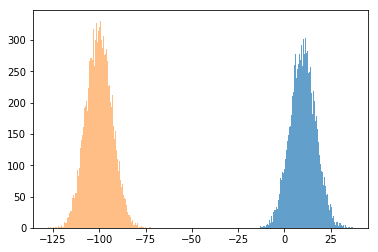

In [218]:
from pyspark.sql.functions import udf, col
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pyspark
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()
pd_df = pd.DataFrame()
pd_df["col1"] = np.random.normal(10, 7, size=10000)
pd_df["col2"] = np.random.normal(-100, 7, size=10000)
df = spark.createDataFrame(pd_df)
df.printSchema()

def ranker(list_one, list_two):
    return {
        # least stringent
        "ks_2samp": stats.ks_2samp(list_one, list_two)[1],
        # assumes a dependency structure
        "wilcoxon": stats.wilcoxon(list_one, list_two)[1],
        # most stringent
        "mann_whitney_u": stats.mannwhitneyu(list_one, list_two)[1],
        "spearman": stats.spearmanr(list_one, list_two)[1]
    }

def transform_columns(data_frame: pyspark.sql.DataFrame, column_one: str, column_two: str) -> (list, list):
    listing_one = df.select(column_one).collect()
    listing_two = df.select(column_two).collect()
    listing_one = [elem.asDict()[column_one] for elem in listing_one]
    listing_two = [elem.asDict()[column_two] for elem in listing_two]
    return listing_one, listing_two


def similarity_score(data_frame: pyspark.sql.DataFrame, column_one:str, column_two: str) -> list:
    score_list = []
    col1_list, col2_list = transform_columns(data_frame, column_one, column_two)
    score_list.append(ranker(col1_list, col2_list))
    return score_list
  
print(similarity_score(df, "col1", "col2"))
col1, col2 = transform_columns(df, "col1", "col2")
plt.hist(col1, bins=100, alpha=0.7) 
plt.hist(col2, bins=100, alpha=0.5)
plt.show()